# Feature extractor for the NFL data bowl

List of features that we may want to get into our dataframe before passing it to a model

- Possibile Features:
    - Rusher
        - X
       
        - S
            - Horizontal
            - Vertical
        - A
        - Dis
        - Orientation
        - NflId
        - mean_yards_season
        - mean_yards
    - Defense
        - DefendersInTheBox
            - Centroid
            - Radius
            - Largest Gap
                - Horizontal
                - Vertical
            - Spread Y
        - DL
        - LB
    - Offense
        - OffenseFormation
        - RB
        - TE
        - WR
    - YardLine
    - Quarter
    - Down
    - Distance
    - Position
    - min_time_to_tackle
    - is_first_and_ten
    - num_defense_x_distance_away
    - num_team_members_in_hole
    - is_going_wide
    - is_going_for_goal
    - is_first_and_ten
    - distance_to_QB
    - players_in_cone_of_movement
    - num_defense_matched
    - num_defense_in_the_hole_matched
    - distance_to_los
    

In [243]:
# Imports
import os
import datetime

import pandas as pd
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 100)
np.set_printoptions(linewidth=1000)
import numpy as np
import math
import seaborn as sns
from scipy.spatial import distance, ConvexHull, Voronoi
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.preprocessing import StandardScaler

In [18]:
import os
import sys
import timeit
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import matplotlib.pylab as plt
import seaborn as sns
import scipy as sp
import lightgbm as lgb
# !pip install lofo-importance
# from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import display

pd.set_option('max_columns', 200)
pd.set_option('max_rows', 100)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)

# Mean yards of rushers. Will remove when 2019 has been added tio train
rusher_yards = {
    2019: {"Dalvin Cook": [203, 4.9], "Christian McCaffrey": [185, 5.3], "Nick Chubb": [174, 5.3],
           "Derrick Henry": [187, 4.4], "Leonard Fournette": [174, 4.8], "Josh Jacobs": [168, 4.8],
           "Ezekiel Elliott": [178, 4.4], "Chris Carson": [175, 4.4], "Marlon Mack": [178, 4.2],
           "Carlos Hyde": [149, 4.7], "Lamar Jackson": [106, 6.6], "Mark Ingram": [123, 5.0], "Aaron Jones": [135, 4.4],
           "Phillip Lindsay": [118, 4.9], "Jordan Howard": [119, 4.4], "Matt Breida": [99, 5.3],
           "Adrian Peterson": [115, 4.3], "Sony Michel": [144, 3.3], "David Montgomery": [129, 3.6],
           "Le'Veon Bell": [143, 3.1], "Frank Gore": [111, 4.0], "Joe Mixon": [131, 3.3], "Todd Gurley": [104, 4.1],
           "Ronald Jones": [103, 4.0], "Saquon Barkley": [101, 4.0], "Alvin Kamara": [90, 4.4],
           "Alexander Mattison": [79, 4.9], "James Conner": [97, 3.9], "Royce Freeman": [93, 4.0],
           "Devonta Freeman": [107, 3.5], "LeSean McCoy": [72, 5.2], "Latavius Murray": [85, 4.4],
           "Tevin Coleman": [83, 4.3], "Kyler Murray": [59, 5.9], "Austin Ekeler": [90, 3.8],
           "Miles Sanders": [76, 4.4], "Peyton Barber": [94, 3.4], "Devin Singletary": [48, 6.4],
           "Kerryon Johnson": [92, 3.3], "Raheem Mostert": [55, 5.6], "David Johnson": [82, 3.7],
           "Damien Williams": [79, 3.8], "Melvin Gordon": [86, 3.5], "Chase Edmonds": [58, 5.1],
           "Jamaal Williams": [65, 4.5], "Duke Johnson": [54, 5.3], "Deshaun Watson": [52, 5.4],
           "Gus Edwards": [63, 4.4], "Josh Allen": [67, 4.1], "Gardner Minshew": [42, 5.6], "Tony Pollard": [49, 4.6],
           "Daniel Jones": [32, 6.5], "Russell Wilson": [44, 4.6], "Mark Walton": [53, 3.8], "J.D. McKissic": [30, 5.9],
           "Dak Prescott": [27, 6.5], "Rashaad Penny": [34, 4.9], "Jordan Wilkins": [27, 6.1],
           "Malcolm Brown": [42, 3.9], "Ty Johnson": [44, 3.5], "Justin Jackson": [20, 7.5], "Kenyan Drake": [25, 5.8],
           "Carson Wentz": [37, 3.9], "Jameis Winston": [31, 4.5], "Rex Burkhead": [31, 4.3],
           "DeAndre Washington": [38, 3.5], "Marcus Mariota": [24, 5.4], "Darrell Henderson": [33, 3.7],
           "Benny Snell": [28, 4.2], "Kalen Ballage": [55, 2.1], "Jacoby Brissett": [37, 3.0],
           "Wayne Gallman": [28, 3.9], "Aaron Rodgers": [27, 4.0], "Ito Smith": [22, 4.8], "James White": [32, 3.3],
           "Brian Hill": [28, 3.6], "Unknown": [0, 4.2]},
    2018: {"Ezekiel Elliott": [304, 4.7], "Saquon Barkley": [261, 5.0], "David Johnson": [258, 3.6],
           "Todd Gurley": [256, 4.9], "Adrian Peterson": [251, 4.2], "Jordan Howard": [250, 3.7],
           "Chris Carson": [247, 4.7], "Joe Mixon": [237, 4.9], "Peyton Barber": [234, 3.7],
           "Christian McCaffrey": [219, 5.0], "James Conner": [215, 4.5], "Derrick Henry": [215, 4.9],
           "Lamar Miller": [210, 4.6], "Sony Michel": [209, 4.5], "Marlon Mack": [195, 4.7], "Alvin Kamara": [194, 4.6],
           "Nick Chubb": [192, 5.2], "Phillip Lindsay": [192, 5.4], "Kareem Hunt": [181, 4.6],
           "Melvin Gordon": [175, 5.1], "Doug Martin": [172, 4.2], "Tevin Coleman": [167, 4.8],
           "LeSean McCoy": [161, 3.2], "Frank Gore": [156, 4.6], "Dion Lewis": [155, 3.3],
           "LeGarrette Blount": [154, 2.7], "Matt Breida": [153, 5.3], "Alfred Blue": [150, 3.3],
           "Lamar Jackson": [147, 4.7], "Isaiah Crowell": [143, 4.8], "atavius Murray": [140, 4.1],
           "Mark Ingram": [138, 4.7], "Gus Edwards": [137, 5.2], "Dalvin Cook": [133, 4.6],
           "Leonard Fournette": [133, 3.3], "Aaron Jones": [133, 5.5], "Royce Freeman": [130, 4.0],
           "Jamaal Williams": [121, 3.8], "Josh Adams": [120, 4.3], "Kenyan Drake": [120, 4.5],
           "Kerryon Johnson": [118, 5.4], "Chris Ivory": [115, 3.3], "Alex Collins": [114, 3.6],
           "Mike Davis": [112, 4.6], "Alfred Morris": [111, 3.9], "Austin Ekeler": [106, 5.2],
           "T.J. Yeldon": [104, 4.0], "Cam Newton": [101, 4.8], "Tarik Cohen": [99, 4.5], "Deshaun Watson": [99, 5.6],
           "James White": [94, 4.5], "Elijah McGuire": [92, 3.0], "Marshawn Lynch": [90, 4.2], "Ito Smith": [90, 3.5],
           "Josh Allen": [89, 7.1], "Wendell Smallwood": [87, 4.2], "Nyheim Hines": [85, 3.7],
           "Rashaad Penny": [85, 4.9], "Bilal Powell": [80, 4.3], "Dak Prescott": [75, 4.1], "Corey Clement": [68, 3.8],
           "Mitchell Trubisky": [68, 6.2], "Russell Wilson": [67, 5.6], "Jeff Wilson": [66, 4.0],
           "Marcus Mariota": [64, 5.6], "Kenneth Dixon": [60, 5.6], "Chase Edmonds": [60, 3.5],
           "Patrick Mahomes": [60, 4.5], "Jordan Wilkins": [60, 5.6], "Blake Bortles": [58, 6.3],
           "Carlos Hyde": [58, 3.3], "Rex Burkhead": [57, 3.3], "Giovani Bernard": [56, 3.8],
           "Jaylen Samuels": [56, 4.6], "Jalen Richard": [55, 4.7], "Zach Zenner": [55, 4.8],
           "Marcus Murphy": [52, 4.8], "Wayne Gallman": [51, 3.5], "Spencer Ware": [51, 4.8],
           "Justin Jackson": [50, 4.1], "Damien Williams": [50, 5.1], "Jameis Winston": [49, 5.7],
           "Andrew Luck": [46, 3.2], "Jay Ajayi": [45, 4.1], "Kirk Cousins": [44, 2.8], "Sam Darnold": [44, 3.1],
           "Rod Smith": [44, 2.9], "C.J. Anderson": [43, 7.0], "Malcolm Brown": [43, 4.9], "Jared Goff": [43, 2.5],
           "Aaron Rodgers": [43, 6.3], "Chris Thompson": [43, 4.1], "Cordarrelle Patterson": [42, 5.4],
           "Javorius Allen": [41, 2.7], "Alex Smith": [41, 4.1], "Duke Johnson": [40, 5.0], "Theo Riddick": [40, 4.3],
           "Baker Mayfield": [39, 3.4], "Trenton Cannon": [38, 3.0], "Taysom Hill": [37, 5.3],
           "Kalen Ballage": [36, 5.3], "Ryan Fitzpatrick": [36, 4.2], "Devontae Booker": [34, 5.4],
           "Raheem Mostert": [34, 7.7], "Carson Wentz": [34, 2.7], "Jacquizz Rodgers": [33, 3.2],
           "Matt Ryan": [33, 3.8], "Ryan Tannehill": [32, 4.5], "Drew Brees": [31, 0.7],
           "Ben Roethlisberger": [31, 3.2], "DeAndre Washington": [30, 3.8], "Unknown": [0, 4.355]},
    2017: {"Le'Veon Bell": [321, 4.0], "LeSean McCoy": [287, 4.0], "Melvin Gordon": [284, 3.9],
           "Todd Gurley": [279, 4.7], "Jordan Howard": [276, 4.1], "Kareem Hunt": [272, 4.9],
           "Leonard Fournette": [268, 3.9], "Frank Gore": [261, 3.7], "C.J. Anderson": [245, 4.1],
           "Ezekiel Elliott": [242, 4.1], "Carlos Hyde": [240, 3.9], "Lamar Miller": [238, 3.7],
           "Mark Ingram": [230, 4.9], "Latavius Murray": [216, 3.9], "Alex Collins": [212, 4.6],
           "Marshawn Lynch": [207, 4.3], "Isaiah Crowell": [206, 4.1], "Jonathan Stewart": [198, 3.4],
           "Devonta Freeman": [196, 4.4], "DeMarco Murray": [184, 3.6], "Dion Lewis": [180, 5.0],
           "Joe Mixon": [178, 3.5], "Bilal Powell": [178, 4.3], "Derrick Henry": [176, 4.2],
           "Samaje Perine": [175, 3.4], "LeGarrette Blount": [173, 4.4], "Orleans Darkwa": [171, 4.4],
           "Ameer Abdullah": [165, 3.3], "Tevin Coleman": [156, 4.0], "Javorius Allen": [153, 3.9],
           "Jamaal Williams": [153, 3.6], "Jerick McKinnon": [150, 3.8], "Cam Newton": [139, 5.4],
           "Doug Martin": [138, 2.9], "Kenyan Drake": [133, 4.8], "Adrian Peterson": [129, 3.5],
           "Alvin Kamara": [120, 6.1], "Kerwynn Williams": [120, 3.6], "Christian McCaffrey": [117, 3.7],
           "Alfred Morris": [115, 4.8], "Chris Ivory": [112, 3.4], "Wayne Gallman": [111, 4.3],
           "Peyton Barber": [108, 3.9], "Giovani Bernard": [105, 4.4], "Matt Breida": [105, 4.4],
           "Mike Gillislee": [104, 3.7], "Matt Forte": [103, 3.7], "Russell Wilson": [95, 6.2],
           "Marlon Mack": [93, 3.8], "Elijah McGuire": [88, 3.6], "Tarik Cohen": [87, 4.3], "Theo Riddick": [84, 3.4],
           "Tyrod Taylor": [84, 5.1], "Duke Johnson": [82, 4.2], "Aaron Jones": [81, 5.5], "Devontae Booker": [79, 3.8],
           "D'Onta Foreman": [78, 4.2], "DeShone Kizer": [77, 5.4], "Corey Clement": [74, 4.3],
           "Dalvin Cook": [74, 4.8], "Alfred Blue": [71, 3.7], "Ty Montgomery": [71, 3.8], "Jay Ajayi": [70, 5.8],
           "Jamaal Charles": [69, 4.3], "Eddie Lacy": [69, 2.6], "Mike Davis": [68, 3.5], "Mike Tolbert": [66, 3.7],
           "Rex Burkhead": [64, 4.1], "Jacquizz Rodgers": [64, 3.8], "Chris Thompson": [64, 4.6],
           "Carson Wentz": [64, 4.7], "Jacoby Brissett": [63, 4.1], "Malcolm Brown": [63, 3.9], "Rob Kelley": [62, 3.1],
           "Marcus Mariota": [60, 5.2], "Alex Smith": [60, 5.9], "Tavon Austin": [59, 4.6], "Thomas Rawls": [58, 2.7],
           "Blake Bortles": [57, 5.6], "Dak Prescott": [57, 6.3], "DeAndre Washington": [57, 2.7],
           "Jalen Richard": [56, 4.9], "Rod Smith": [55, 4.2], "Chris Carson": [49, 4.2], "Kirk Cousins": [49, 3.7],
           "T.J. Yeldon": [49, 5.2], "Austin Ekeler": [47, 5.5], "Wendell Smallwood": [47, 3.7],
           "J.D. McKissic": [46, 4.1], "Damien Williams": [46, 3.9], "Chris Johnson": [45, 2.5],
           "Shane Vereen": [45, 3.6], "James White": [43, 4.0], "Tion Green": [42, 3.9], "Paul Perkins": [41, 2.2],
           "Mitchell Trubisky": [41, 6.0], "Case Keenum": [40, 4.0], "Terrance West": [39, 3.5],
           "Andy Dalton": [38, 2.6], "Jeremy Hill": [37, 3.1], "Josh McCown": [37, 3.4], "Brett Hundley": [36, 7.5],
           "Deshaun Watson": [36, 7.5], "Branden Oliver": [35, 2.4], "Drew Brees": [33, 0.4],
           "Jameis Winston": [33, 4.1], "James Conner": [32, 4.5], "Matt Ryan": [32, 4.5], "Elijhaa Penny": [31, 4.0],
           "Trevor Siemian": [31, 4.1], "Corey Grant": [30, 8.3], "Terron Ward": [30, 4.3], "Unknown": [0, 3.868]}
}


class PersistentFeatures:
    def __init__(self, settings, nfl_df):
        self.nfl = nfl_df
        self.rushers = self.nfl.loc[self.nfl.NflId == self.nfl.NflIdRusher]
        self.rushers.set_index('PlayId', inplace=True)
        self.rusher_features = pd.DataFrame(self.rushers['NflId'].unique(), columns=['NflId'])
        self.columns = []
        self.standard_scalers = []
        self.min_max_scalers = []
        self.settings = settings

    def build_features(self):
        self._rusher_features()

    def attach_columns(self, columns):
        self.columns = columns

    def fit(self, x, fold):
        self.standard_scalers.append(StandardScaler())
        self.standard_scalers[fold].fit(x[self.settings.get_features()])
        self.min_max_scalers.append(MinMaxScaler())
        self.min_max_scalers[fold].fit(x[self.settings.categorical_features()])
        
    def transform(self, x_df, fold):
        x = x_df.copy()
        x[self.settings.get_features()] = self.standard_scalers[fold].transform(x_df[self.settings.get_features()])
        x[self.settings.categorical_features()] = self.min_max_scalers[fold].transform(x_df[self.settings.categorical_features()])
        return x

    def _rusher_features(self):
        self._rusher_mean_yards()

    def _rusher_mean_yards(self):
        mean_dict = self.rushers.groupby(['Season', 'NflId'])['Yards'].mean()
        for year in range(2017, 2020):
            try:
                self.rusher_features["RusherMeanYards_{}".format(year)] = self.rusher_features['NflId'].map(
                    mean_dict[year])
            except IndexError:
                pass
        mean_dict = self.rushers.groupby('NflId')['Yards'].mean().to_dict()
        self.rusher_features['RusherMeanYards'] = self.rusher_features['NflId'].map(mean_dict)


def stringtomins(x):
    h, m, s = map(int, x.split(':'))
    return (h * 60) + m + (s / 60)


class FeatureExtractor:
    PICKLE_PATH = './features.pkl'

    def __init__(self, settings, nfl_df, persistent_features, is_train=True):
        self.settings = settings
        self.nfl = nfl_df
        self.persistent_features = persistent_features
        self._normalise_starting_df()
        self.rushers = self.nfl.loc[self.nfl.IsRusher]
        self.features = self.rushers[['PlayId', 'GameId', 'NflId']]
        self.rushers.set_index('PlayId', inplace=True)
        self.features.set_index('PlayId', inplace=True)
        self.is_train = is_train

    def run(self):
        if self.is_train and self.settings.load_features and self.load_if_exists():
            print("Loaded features for train set from pickle.")
            return
        self.attach_persistent_features()
        self.rusher_features()
        self.splitting_features()
        self.game_features()
        self.defense_features()
        self.offense_features()
        self.play_features()
        self.voronoi_features()
        self.features = self.features.fillna(self.features.mean())
        if self.is_train:
            self.features.to_pickle(self.PICKLE_PATH)

    def load_if_exists(self):
        if os.path.exists(self.PICKLE_PATH):
            self.features = pd.read_pickle(self.PICKLE_PATH)
            return True
        return False

    def get_useable_features(self):
        base_columns = ['GameId', 'PossessionTeam']
        columns = base_columns + self.settings.categorical_features() + self.settings.get_features()
        return self.features[columns]

    def get_features_with_yards(self):
        return self.get_useable_features().join(self.rushers['Yards'])

    def attach_missing_columns(self, persistent_columns):
        missing_cols = set(persistent_columns) - set(self.features.columns)
        for c in missing_cols:
            self.features[c] = 0

    def attach_persistent_features(self):
        self.features.reset_index().merge(self.persistent_features.rusher_features, on='NflId').set_index('PlayId')

    def splitting_features(self):
        self.features['IsFirstAndTenRB'] = self.rushers['IsFirstAndTen']
        self.features.loc[(self.rushers.Position != 'RB'), 'IsFirstAndTenRB'] = 0
        self.features['IsGoingLong'] = 0
        self.features.loc[(self.rushers.Distance > 14.0), 'IsGoingLong'] = 1
        self.features['IsGoingShort'] = 0
        self.features.loc[(self.rushers.Distance < 5.0), 'IsGoingShort'] = 1
        self.features['IsRunningForTD'] = 0
        self.features.loc[(self.rushers.YardLine_std > 94), 'IsRunningForTD'] = 1
        self.features['IsQB'] = 0
        self.features.loc[(self.rushers.Position == 'QB'), 'IsQB'] = 1
        self.features['IsGoingWide'] = (np.abs(self.features['Dir_std']) > 0.95) & (
                np.abs(self.features['Dir_std']) < 1.57)
        self.features['IsGoingBackwards'] = (np.abs(self.features['Dir_std']) > 1.57)
        self.features['IsLookingBackwards'] = 0
        self.features.loc[self.features.Orientation2 > 180, 'IsLookingBackwards'] = 1

    def play_features(self):
        self.features['DistanceToQB'] = np.sqrt(np.sum(
            self.nfl.loc[(self.nfl.Position == 'QB') | self.nfl.IsRusher, ['PlayId', 'X_std', 'Y_std']].groupby(
                'PlayId').agg(['min', 'max']).diff(axis=1).drop([('X_std', 'min'), ('Y_std', 'min')], axis=1) ** 2,
            axis=1))
        self.distances_to_rusher_features()
        self.features['MinTimeToTackle'] = np.abs(self.nfl.loc[~self.nfl.IsOnOffense & (self.nfl.RankDisFromPlayStart == 1), 'DisToRusher'])\
                                            / (np.abs(self.nfl.loc[~self.nfl.IsOnOffense & (self.nfl.RankDisFromPlayStart == 1), 'S'])\
                                                 + np.abs(self.nfl.loc[self.nfl.IsRusher, 'S']))
        self.features['MinTimeToTackle'] = self.features['MinTimeToTackle'].fillna(100)                                                     

    def distances_to_rusher_features(self):
        self.features['D_Dis_to_R_Min'] = self.nfl.loc[~self.nfl.IsOnOffense].groupby(['PlayId'])[
            'DisToRusher'].min()
        self.features['D_Dis_to_R_Max'] = self.nfl.loc[~self.nfl.IsOnOffense].groupby(['PlayId'])[
            'DisToRusher'].max()
        self.features['D_Dis_to_R_Mean'] = self.nfl.loc[~self.nfl.IsOnOffense].groupby(['PlayId'])[
            'DisToRusher'].mean()
        self.features['D_Dis_to_R_Std'] = self.nfl.loc[~self.nfl.IsOnOffense].groupby(['PlayId'])[
            'DisToRusher'].std()
        self.features['Dis_to_R_Min'] = self.nfl.loc[self.nfl.IsRusher == 0].groupby(['PlayId'])[
            'DisToRusher'].min()
        self.features['Dis_to_R_Max'] = self.nfl.loc[self.nfl.IsRusher == 0].groupby(['PlayId'])[
            'DisToRusher'].max()
        self.features['Dis_to_R_Mean'] = self.nfl.loc[self.nfl.IsRusher == 0].groupby(['PlayId'])[
            'DisToRusher'].mean()
        self.features['Dis_to_R_Std'] = self.nfl.loc[self.nfl.IsRusher == 0].groupby(['PlayId'])[
            'DisToRusher'].std()
        self.features['D_Dis_to_R_Mean_in_1'] = self.nfl.loc[~self.nfl.IsOnOffense].groupby(['PlayId'])[
            'DisToRusher_in_1'].mean()
        self.features['D_Dis_to_R_Min_in_1'] = self.nfl.loc[~self.nfl.IsOnOffense].groupby(['PlayId'])[
            'DisToRusher_in_1'].min()
        self.features['D_Dis_to_R_Mean_in_2'] = self.nfl.loc[~self.nfl.IsOnOffense].groupby(['PlayId'])[
            'DisToRusher_in_2'].mean()
        self.features['D_Dis_to_R_Min_in_2'] = self.nfl.loc[~self.nfl.IsOnOffense].groupby(['PlayId'])[
            'DisToRusher_in_2'].min()
        self.features['D_Dis_to_R_Mean_in_3'] = self.nfl.loc[~self.nfl.IsOnOffense].groupby(['PlayId'])[
            'DisToRusher_in_3'].mean()
        self.features['D_Dis_to_R_Min_in_3'] = self.nfl.loc[~self.nfl.IsOnOffense].groupby(['PlayId'])[
            'DisToRusher_in_3'].min()

    def defense_features(self):
        self.features['Def_DL'] = np.array(self.rushers['DefensePersonnel'].str[:1], dtype='int8')
        self.features['Def_LB'] = np.array(self.rushers['DefensePersonnel'].str[6:7], dtype='int8')
        self.features['Def_DB'] = np.array(self.rushers['DefensePersonnel'].str[12:13], dtype='int8')

        self.features['D_A_mean'] = self.nfl.loc[~self.nfl.IsOnOffense].groupby(['PlayId'])['A'].mean()
        self.features['D_S_mean'] = self.nfl.loc[~self.nfl.IsOnOffense].groupby(['PlayId'])['S'].mean()
        self._defenders_in_the_box()

    def _defenders_in_the_box(self):
        self.features['DefendersInTheBox'] = self.rushers['DefendersInTheBox']
        self.features['DITB_Centroid_X'] = \
            self.nfl.loc[self.nfl.IsDefenderInBox].groupby('PlayId')[['X_std']].mean()
        self.features['DITB_Centroid_Y'] = \
            self.nfl.loc[self.nfl.IsDefenderInBox].groupby('PlayId')[['Y_std']].mean()
        self.features['DITB_Spread_X'] = \
            self.nfl.loc[self.nfl.IsDefenderInBox].groupby('PlayId')['X_std'].agg(['min', 'max']).diff(axis=1)[
                'max']
        self.features['DITB_Spread_Y'] = \
            self.nfl.loc[self.nfl.IsDefenderInBox].groupby('PlayId')['Y_std'].agg(['min', 'max']).diff(axis=1)[
                'max']

        self.features['DITB_Centroid_X_Dis_to_rusher'] = \
            np.absolute(self.features['DITB_Centroid_X'] - self.rushers['X_std'])
        self.features['DITB_Centroid_Y_Dis_to_rusher'] = \
            np.absolute(self.features['DITB_Centroid_Y'] - self.rushers['Y_std'])
        
        self.features['DITB_A_mean'] = self.nfl.loc[self.nfl.IsDefenderInBox].groupby(['PlayId'])['A'].mean()
        self.features['DITB_S_mean'] = self.nfl.loc[self.nfl.IsDefenderInBox].groupby(['PlayId'])['S'].mean()

    def offense_features(self):
        self.features['Off_RB'] = np.array(self.rushers['OffensePersonnel'].str.extract('(\d) RB'), dtype='int8')
        self.features['Off_TE'] = np.array(self.rushers['OffensePersonnel'].str.extract('(\d) TE'), dtype='int8')
        self.features['Off_WR'] = np.array(self.rushers['OffensePersonnel'].str.extract('(\d) WR'), dtype='int8')
        #         self.features['OffenseFormation'] = self.rushers['OffenseFormation']
        off_formations = [pd.get_dummies(self.rushers['OffenseFormation'], prefix='Off_Formation')]
        self.features = self.features.join(off_formations)

    def game_features(self):
        self.features['Week'] = self.rushers['Week']
        self.features['Season_2017'] = self.features['Season_2018'] = self.features['Season_2019'] = 0
        self.features.loc[self.rushers.Season == 2017, 'Season_2017'] = 1
        self.features.loc[self.rushers.Season == 2018, 'Season_2018'] = 1
        self.features.loc[self.rushers.Season == 2019, 'Season_2019'] = 1

        self.features['Quarter'] = self.rushers['Quarter']
        self.features['GameClock_std'] = (900.0 - self.rushers['GameClock'].apply(stringtomins)) / 900.0
        self.features['FullGameClock_std'] = (self.features['GameClock_std'] / 4.0) + (
                (self.features['Quarter'] - 1) * 0.25)

        self.features['OffenseScoreDelta'] = self.rushers['HomeScoreBeforePlay'] - self.rushers[
            'VisitorScoreBeforePlay']
        self.features['ScoreUrgency'] =  self.rushers['Quarter'] * self.features['OffenseScoreDelta']
        self.features['DefendersInTheBox_vs_Distance'] = self.rushers['DefendersInTheBox'] / self.rushers['Distance']
        self.features.loc[self.rushers.PossessionTeam != self.rushers.HomeTeamAbbr, 'OffenseScoreDelta'] \
            = -1 * self.features.loc[self.rushers.PossessionTeam != self.rushers.HomeTeamAbbr, 'OffenseScoreDelta']

        self.features['YardLine_std'] = self.rushers['YardLine_std']
        self.features['Down'] = self.rushers['Down']

    def rusher_features(self):
        rushers_features = self.rushers[['S', 'A', 'Dis', 'Orientation', 'Orientation2', 'Dir', 'Dir2',
                                         'PlayerHeight', 'PlayerWeight', 'X_std', 'Y_std', 'Dir_rad', 'Dir_std',
                                         'S_std', 'Distance', 'YardLine', 'A_horizontal','A_vertical',
                                         'S_horizontal','S_vertical','S_std_horizontal','S_std_vertical',
                                        'PossessionTeam', 'Orientation_rad']].copy(deep=True)
        rushers_features['PlayerHeight'] = rushers_features['PlayerHeight'] \
            .apply(lambda x: 12 * int(x.split('-')[0]) + int(x.split('-')[1]))

        self.features = self.features.join(rushers_features)
        self._rusher_position_ohe()
        self.features['RusherMeanYardsSeason'] = self.rushers.apply(self.get_rusher_mean_yards, index=1, axis=1)
        self.features['Back_from_Scrimmage'] = self.rushers['YardLine_std'] - self.rushers['X_std']
        self.features["Dir_sin"] = np.sin(self.rushers['Dir_std'])
        self.features["Dir_cos"] = np.cos(self.rushers['Dir_std'])
        self.features['Dir_vs_Orientation'] = np.abs(self.rushers['Dir_std'] - self.rushers['Orientation_rad'])
        
    def get_rusher_mean_yards(self, row, index):
        try:
            return rusher_yards[row['Season']][row['DisplayName']][index]
        except:
            return rusher_yards[row['Season']]['Unknown'][index]

    def _rusher_position_ohe(self):
        #         self.features['Position'] = self.rushers['Position']
        rusher_position = [pd.get_dummies(self.rushers['Position'], prefix='Rusher_Position')]
        self.features = self.features.join(rusher_position)

    def _normalise_starting_df(self):
        self._fix_team_abbr()
        self._fix_orientation()
        self._fix_speed()
        self._add_possession_columns()
        self._flip_left_plays()
        self._distance_to_centers()
        self._vectors()
        self.all_positions_after_t_seconds()
        self._distances_to_rusher()
        for i in range(1,5):
            self._distances_to_rusher("_in_" + str(i))
        self.nfl['IsFirstAndTen'] = 1
        self.nfl.loc[(self.nfl.Distance != 10.0) | (self.nfl.Down != 1), 'IsFirstAndTen'] = 0

    def _distances_to_rusher(self, t=''):
        nfl_copy = self.nfl.copy()
        rusher = nfl_copy.loc[nfl_copy.IsRusher]
        rusher.set_index('PlayId', inplace=True)
        nfl_copy['Rusher_X_std'] = nfl_copy['PlayId'].map(rusher['X_std' + t].to_dict())
        nfl_copy['Rusher_Y_std'] = nfl_copy['PlayId'].map(rusher['Y_std' + t].to_dict())
        distances_to_rusher = (nfl_copy.X_std - nfl_copy.Rusher_X_std) ** 2 + (
                nfl_copy.Y_std - nfl_copy.Rusher_Y_std) ** 2
        self.nfl['DisToRusher' + t] = np.sqrt(distances_to_rusher)
        
    def _vectors(self):
        self.nfl['A_horizontal'] = self.nfl['A'] * np.cos(self.nfl['Dir_rad'])
        self.nfl['A_vertical'] = self.nfl['A'] * np.sin(self.nfl['Dir_rad'])
        self.nfl['S_horizontal'] = self.nfl['S'] * np.cos(self.nfl['Dir_rad'])
        self.nfl['S_vertical'] = self.nfl['S'] * np.sin(self.nfl['Dir_rad'])
        self.nfl['S_std_horizontal'] = self.nfl['S_std'] * np.cos(self.nfl['Dir_rad'])
        self.nfl['S_std_vertical'] = self.nfl['S_std'] * np.sin(self.nfl['Dir_rad'])
        
    def _fix_team_abbr(self):
        map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
        for abb in self.nfl['PossessionTeam'].unique():
            map_abbr[abb] = abb
        self.nfl['PossessionTeam'] = self.nfl['PossessionTeam'].map(map_abbr)
        self.nfl['HomeTeamAbbr'] = self.nfl['HomeTeamAbbr'].map(map_abbr)
        self.nfl['VisitorTeamAbbr'] = self.nfl['VisitorTeamAbbr'].map(map_abbr)

    def _fix_orientation(self):
        self.nfl['Orientation2'] = self.nfl['Orientation']
        self.nfl.loc[self.nfl['Season'] == 2017, 'Orientation'] \
            = np.mod(90 + self.nfl.loc[self.nfl['Season'] == 2017, 'Orientation'], 360)
        
    def _fix_speed(self):
        self.nfl['S_std'] = self.nfl['S']
        self.nfl.loc[self.nfl['Season'] == 2017, 'S'] \
            = (self.nfl['S'][self.nfl['Season'] == 2017] - 2.4355) / 1.2930 * 1.4551 + 2.7570
        

    def _flip_left_plays(self):
        self.nfl['ToLeft'] = self.nfl.PlayDirection == "left"
        self.nfl['YardLine_std'] = 100 - self.nfl.YardLine
        self.nfl.loc[self.nfl.FieldPosition.fillna('') == self.nfl.PossessionTeam, 'YardLine_std'] \
            = self.nfl.loc[self.nfl.FieldPosition.fillna('') == self.nfl.PossessionTeam, 'YardLine']

        self.nfl['X_std'] = self.nfl.X
        self.nfl.loc[self.nfl.ToLeft, 'X_std'] = 120 - self.nfl.loc[self.nfl.ToLeft, 'X']
        self.nfl['Y_std'] = self.nfl.Y - 160 / 6
        self.nfl.loc[self.nfl.ToLeft, 'Y_std'] = 160 / 6 - self.nfl.loc[self.nfl.ToLeft, 'Y']
        self.nfl.loc[self.nfl['Y_std'] >= 160 / 6, 'Y_std'] = 26.6

        self.nfl.loc[self.nfl.ToLeft, 'Orientation2'] = 360 - self.nfl.loc[self.nfl.ToLeft, 'Orientation2']
        self.nfl.loc[self.nfl.ToLeft, 'Orientation'] = np.mod(180 + self.nfl.loc[self.nfl.ToLeft, 'Orientation'], 360)
        self.nfl['Orientation_std'] = np.mod(90 - self.nfl.Orientation, 360)*math.pi / 180
        self.nfl['Dir2'] = self.nfl['Dir']
        self.nfl.loc[self.nfl.ToLeft, 'Dir2'] = 360 - self.nfl.loc[self.nfl.ToLeft, 'Dir2']
        self.nfl['Dir_rad'] = np.mod(270 - self.nfl.Dir, 360) * math.pi / 180.0
        self.nfl['Dir_std'] = self.nfl.Dir_rad
        self.nfl.loc[self.nfl.ToLeft, 'Dir_std'] = np.mod(np.pi + self.nfl.loc[self.nfl.ToLeft, 'Dir_rad'],
                                                          2 * np.pi)
        self.nfl['Dir_std'] = self.nfl['Dir_std'] - math.pi

    def _add_possession_columns(self):
        self.nfl['IsRusher'] = self.nfl.NflId == self.nfl.NflIdRusher
        self.nfl['TeamOnOffense'] = "home"
        self.nfl.loc[self.nfl.PossessionTeam != self.nfl.HomeTeamAbbr, 'TeamOnOffense'] = "away"
        self.nfl['IsOnOffense'] = self.nfl.Team == self.nfl.TeamOnOffense

    def _distance_to_centers(self):
        self.nfl['DisFromPlayStart'] = np.sqrt(
            (self.nfl.X_std - self.nfl.YardLine_std - 10) ** 2 + (self.nfl.Y_std ** 2))
        ranks = self.nfl.groupby(['PlayId', 'IsOnOffense'])['DisFromPlayStart'] \
            .rank(ascending=True, method='first')
        ranks.name = 'RankDisFromPlayStart'
        self.nfl = pd.concat([self.nfl, ranks], axis=1)
        self.nfl['IsDefenderInBox'] = False
        self.nfl.loc[(~self.nfl.IsOnOffense) &
                     (self.nfl.DefendersInTheBox >= self.nfl.RankDisFromPlayStart), ['IsDefenderInBox']] = True
    
    def all_positions_after_t_seconds(self):
        self._positions_after_t_seconds(1)        
        self._positions_after_t_seconds(2)        
        self._positions_after_t_seconds(3)     
        self._positions_after_t_seconds(4)     
        self._positions_after_t_seconds(5)
    
    def _positions_after_t_seconds(self, t):
        if t <= 2:
            self.nfl['X_std_in_{}'.format(t)] = self.nfl['X_std']\
                                + (self.nfl['S_horizontal']*t) + (0.5 * self.nfl['A_horizontal'] * (t ** 2))
            self.nfl['Y_std_in_{}'.format(t)] = self.nfl['Y_std']\
                                +(self.nfl['S_vertical']*t) + (0.5 * self.nfl['A_vertical'] * (t ** 2)) 
        else:
            self.nfl['X_std_in_{}'.format(t)] = self.nfl['X_std']\
                                + ((self.nfl['S_horizontal'] + self.nfl['A_horizontal'] * 2)*2) + (0.5 * self.nfl['A_horizontal'] * (2 ** 2)) \
                                + ((self.nfl['S_horizontal'] + (self.nfl['A_horizontal'] * 2)) * (t-2))
            self.nfl['Y_std_in_{}'.format(t)] = self.nfl['Y_std']\
                                + ((self.nfl['S_vertical'] + self.nfl['A_vertical'] * 2)*2) + (0.5 * self.nfl['A_vertical'] * (2 ** 2)) \
                                + ((self.nfl['S_vertical'] + (self.nfl['A_vertical'] * 2)) * (t-2))
        
    def voronoi_features(self):
        vertices = self.nfl.groupby('PlayId')[['X_std', 'Y_std', 'IsRusher']].apply(
            lambda play: self._get_voronoi_vertices(play)).unstack()
        self.nfl['Voronoi_vertices'] = vertices.values

        areas = vertices.apply(lambda v: sp.spatial.ConvexHull(v).volume)
        self.nfl['Voronoi_area'] = areas.values

        self.features['Voronoi_rusher_area'] = self.nfl.loc[self.nfl.IsRusher, 'Voronoi_area'].values
        self.features['Voronoi_DITB_area'] = \
            self.nfl.loc[self.nfl.IsDefenderInBox].groupby('PlayId')[['Voronoi_area']].sum()
        self.features['Voronoi_Offense_area'] = \
            self.nfl.loc[self.nfl.IsOnOffense].groupby('PlayId')[['Voronoi_area']].sum()
        self.features['Voronoi_Defense_area'] = \
            self.nfl.loc[~self.nfl.IsOnOffense].groupby('PlayId')[['Voronoi_area']].sum()
        self._voronoi_max_offense_box_y()

    def _voronoi_max_offense_box_y(self):
        self.nfl['MaxVoronoriYVertix'] = self.nfl['Voronoi_vertices'].apply(lambda x: x[:, 0].max())
        self.features['MaxVoronoriYVertixRusher'] = self.nfl[self.nfl.IsRusher, 'MaxVoronoriYVertix']
        
        nfl_copy = self.nfl.copy()
        nfl_copy['MaxYDITB'] = nfl_copy['PlayId'] \
            .map(nfl_copy.loc[nfl_copy.IsDefenderInBox].groupby('PlayId')['Y_std'].max().to_dict())
        nfl_copy['MinYDITB'] = nfl_copy['PlayId'] \
            .map(nfl_copy.loc[nfl_copy.IsDefenderInBox].groupby('PlayId')['Y_std'].min().to_dict())
        nfl_copy['YInDITBRange'] = (nfl_copy['MaxYDITB'] + 1 > nfl_copy['Y_std']) & (
                nfl_copy['Y_std'] > nfl_copy['MinYDITB'] - 1)
        
        self.features['MaxVoronoriYVertixOffense'] = \
            self.nfl[nfl_copy.IsOnOffense & nfl_copy.YInDITBRange].groupby('PlayId')['MaxVoronoriYVertix'].max()
        
    
    def get_bounding_box_for_voronoi(self, play):
        rusher_points = np.array(play.loc[play.IsRusher==1, [['X_std', 'Y_std']])
        return np.array([rusher_points[0]-2, rusher_points[0]+16, rusher_points[1]-10, rusher_points[1]+10)
        
    def _get_voronoi_vertices(self, play)):
        points_center = np.array(play.loc[(play.X_std > bounding_box[0]) 
                                            &(play.X_std < bounding_box[0]) 
                                            &(play.Y_std > bounding_box[1]) 
                                            &(play.Y_std < bounding_box[1])], [['X_std', 'Y_std']])
          # [x_min, x_max, y_min, y_max]

        # Mirror points
        points_left = np.copy(points_center)
        points_left[:, 0] = bounding_box[0] - (points_left[:, 0] - bounding_box[0])
        points_right = np.copy(points_center)
        points_right[:, 0] = bounding_box[1] + (bounding_box[1] - points_right[:, 0])
        points_down = np.copy(points_center)
        points_down[:, 1] = bounding_box[2] - (points_down[:, 1] - bounding_box[2])
        points_up = np.copy(points_center)
        points_up[:, 1] = bounding_box[3] + (bounding_box[3] - points_up[:, 1])
        points = np.append(points_center,
                           np.append(np.append(points_left, points_right, axis=0),
                                     np.append(points_down, points_up, axis=0),
                                     axis=0),
                           axis=0)
        vor = sp.spatial.Voronoi(points)

        point_regions = vor.point_region[0:len(points_center[0])]
        all_regions = np.array(vor.regions)
        all_vertices = np.array(vor.vertices)
        vertices = [all_vertices[r] for r in all_regions[point_regions]]

        return pd.Series(vertices)

class Settings:
    def __init__(self):
        self.epochs = 1
        self.batch_size = 256
        self.model_type = 'lgbm'
        self.load_model_if_exists = False
        self.load_features = True

    def get_features(self):
        columns = ['S','A','Dis','Orientation','Dir','PlayerHeight','PlayerWeight','X_std','Y_std',
                   'Dir_rad','Dir_std','S_std','Distance','A_horizontal','A_Vertical',
                   'S_std_horizontal','S_std_vertical','RusherMeanYardsSeason','Back_from_Scrimmage',
                   'Week','Quarter','GameClock_std','FullGameClock_std','OffenseScoreDelta','YardLine_std','Down',
                   'Def_DL','Def_LB','Def_DB','DefendersInTheBox','DITB_Centroid_X','DITB_Centroid_Y','DITB_Spread_X',
                   'DITB_Spread_Y','DITB_Centroid_X_Dis_to_rusher','DITB_Centroid_Y_Dis_to_rusher','Off_RB','Off_TE',
                   'Off_WR','DistanceToQB','MinTimeToTackle','D_Dis_to_R_Min','D_Dis_to_R_Max','D_Dis_to_R_Mean',
                   'D_Dis_to_R_Std','Dis_to_R_Min','Dis_to_R_Max','Dis_to_R_Mean','Dis_to_R_Std','Voronoi_rusher_area',
                   'Voronoi_DITB_area','Voronoi_Offense_area','Voronoi_Defense_area','LargestYForOffenseInBox'
                   ]
        return columns

    def categorical_features(self):
        return ['IsFirstAndTenRB', 'IsGoingLong', 'IsGoingShort', 'IsQB', 'IsGoingWide', 'IsGoingBackwards']

In [24]:
train_df = pd.read_csv('../resources/train.csv', low_memory=False)
settings = Settings()
pf = PersistentFeatures(settings,train_df)
pf.build_features()
fe = FeatureExtractor(settings, train_df, pf)
fe.run()
pf.attach_columns(fe.features.columns)

AttributeError: 'FeatureExtractor' object has no attribute 'feature'

In [27]:
nfl_copy = fe.nfl.copy()
features_copy = fe.features
rushers_copy = fe.rushers.copy()

In [28]:
features_copy.columns

Index(['GameId', 'NflId', 'S', 'A', 'Dis', 'Orientation', 'Orientation2', 'Dir', 'Dir2', 'PlayerHeight',
       ...
       'D_Dis_to_R_Mean_in_2', 'D_Dis_to_R_Min_in_2', 'D_Dis_to_R_Mean_in_3', 'D_Dis_to_R_Min_in_3', 'MinTimeToTackle', 'Voronoi_rusher_area', 'Voronoi_DITB_area', 'Voronoi_Offense_area', 'Voronoi_Defense_area', 'LargestYForOffenseInBox'], dtype='object', length=106)

# Playing Around
 - Absolute A and S horizontal
 - Voronoi x distance to defense
 - Gaps in Voronoi Defense
 - Weather

In [49]:
features_copy['PlayersInXDistance'] = nfl_copy.loc[~nfl_copy.IsOnOffense & (nfl_copy.DisToRusher < 5)]\
                                    [['PlayId','NflId']].groupby(['PlayId']).count()
features_copy['PlayersInXDistance'] = features_copy['PlayersInXDistance'].fillna(0)

In [ ]:
features_copy[['CentripedidalForceToD']] = ((features_copy['PlayerWeight']/32.2)*(features_copy['S']**2))\
                                    / -features_copy['D_Dis_to_R_Min']
features_copy[['CentripedidalForceToD']] = (((features_copy['S']**2))/ -features_copy['D_Dis_to_R_Min']
features_copy[['ForceFromPrevious']] = ((features_copy['S']-features_copy['A'])**2)\
                                    / -features_copy['Dis']
features_copy[['AngularVelocityChange']] = ((features_copy['S']-features_copy['A'])*features_copy['Dir_std'])\
                                    /(features_copy['S']*features_copy['Orientation_std'])





In [ ]:
def closest_opponent_distance(player):
    playid = player['PlayId'].values[0]
    team = player['Team'].values[0]
    x = player['X_std'].values[0]
    y = player['Y_std'].values[0]
    opponents = nfl_copy.loc[(nfl_copy.PlayId == playid) & (nfl_copy.Team != team)]
    opponents_distance = np.sqrt(
            (opponents.X_std - x) ** 2 + (opponents.Y_std - y) ** 2)
    return opponents_distance.min()

nfl_copy['ClosestOpponentDistance'] = nfl_copy[['PlayId', 'NflId', 'Team', 'X_std', 'Y_std']]\
                                .groupby(['PlayId', 'NflId'])\
                                [['PlayId', 'NflId', 'Team', 'X_std', 'Y_std']]\
                                .apply(lambda player: closest_opponent_distance(player)).unstack()
    

In [78]:
def time_to_location_array(player):
    for t in range(0, 5):
        s = player['S'] + (player['A'] * t)
        
    
    
time_to_location_array(rushers[:1])

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,Orientation2,S_std,IsRusher,TeamOnOffense,IsOnOffense,ToLeft,YardLine_std,X_std,Y_std,Orientation_rad,Orientation_std,Dir2,Dir_rad,Dir_std,DisFromPlayStart,RankDisFromPlayStart,IsDefenderInBox,A_horizontal,A_vertical,S_horizontal,S_vertical,S_std_horizontal,S_std_vertical,X_std_in_1,Y_std_in_1,X_std_in_2,Y_std_in_2,X_std_in_3,Y_std_in_3,X_std_in_4,Y_std_in_4,X_std_in_5,Y_std_in_5,DisToRusher,DisToRusher_in_1,DisToRusher_in_2,DisToRusher_in_3,DisToRusher_in_4,IsFirstAndTen,Voronoi_vertices,Voronoi_area
0,2017090700,20170907000118,away,73.91,34.84,1.918039,1.13,0.40,351.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,278.01,1.69,False,home,False,True,35,46.09,-8.173333,1.710597,1.710597,182.82,1.620015,1.620015,8.245694,7.0,False,-0.055594,1.128632,-0.094364,1.915716,-0.083145,1.687953,45.967838,-5.693302,45.790083,-2.084638,45.362153,6.602867,45.156600,10.775846,44.951047,14.948826,6.480872,6.696907,13.614349,36.939203,47.632378,0,"[[48.54258086523799, -7.216270968777587], [48....",9.916028
1,2017090700,20170907000118,away,74.67,32.64,0.488822,1.35,0.01,297.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,332.39,0.42,False,home,False,True,35,45.33,-5.973333,2.659707,2.659707,161.30,1.244420,1.244420,5.982442,4.0,True,0.432828,1.278734,0.156723,0.463017,0.134657,0.397828,45.703136,-4.870949,46.509100,-2.489831,49.262788,5.645590,50.285166,8.666075,51.307544,11.686560,4.593310,4.637591,12.576050,36.429330,47.189783,0,"[[53.77697350543479, -6.065739923007245], [44....",589.036106
2,2017090700,20170907000118,away,74.00,33.20,1.389116,0.59,0.31,273.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,356.99,1.22,False,home,False,True,35,46.00,-6.533333,3.089058,3.089058,157.27,1.174083,1.174083,6.609421,5.0,True,0.227970,0.544178,0.536739,1.281232,0.471395,1.125250,46.650724,-4.980013,47.529417,-2.882514,49.433974,1.663787,50.426652,4.033375,51.419330,6.402963,5.448982,5.069678,12.466032,36.137407,46.877146,0,"[[73.25030763196234, 1.7099643244050953], [71....",15.364908
3,2017090700,20170907000118,away,71.46,27.70,0.488822,0.54,0.02,269.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,0.23,0.42,False,home,False,True,35,48.54,-1.033333,3.145607,3.145607,254.36,2.868623,2.868623,3.687733,3.0,True,-0.520006,0.145580,-0.470723,0.131783,-0.404449,0.113229,47.809274,-0.828761,46.558541,-0.478609,42.967780,0.526653,41.457044,0.949595,39.946308,1.372537,7.820038,2.074729,7.105637,31.297501,42.098046,0,"[[108.31, 4.5098022598870156], [106.675

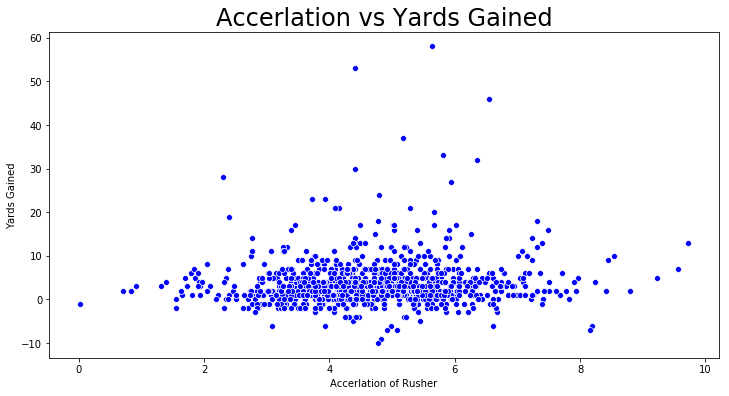

In [100]:
plt.figure(figsize=(12, 6))
rushers_copy['axs'] = rushers_copy['A'] * rushers_copy['S']
# sns.scatterplot(x='A', y='Yards', data=rushers_copy[:1000], color='g')
sns.scatterplot(x='S', y='Yards', data=rushers_copy[:1000], color='b')
# sns.scatterplot(x='axs', y='Yards', data=rushers_copy[:1000], color='r')
# sns.scatterplot(x='S', y='Yards', data=rushers_copy[:1000], color='b')
plt.xlabel('Accerlation of Rusher')
plt.ylabel('Yards Gained')
plt.title('Accerlation vs Yards Gained', fontsize=24)
plt.show()

In [98]:
rushers_copy.loc[rushers_copy.A > 10]

,GameId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,Orientation2,S_std,IsRusher,TeamOnOffense,IsOnOffense,ToLeft,YardLine_std,X_std,Y_std,Orientation_rad,Orientation_std,Dir2,Dir_rad,Dir_std,DisFromPlayStart,RankDisFromPlayStart,IsDefenderInBox,A_horizontal,A_vertical,S_horizontal,S_vertical,S_std_horizontal,S_std_vertical,X_std_in_1,Y_std_in_1,X_std_in_2,Y_std_in_2,X_std_in_3,Y_std_in_3,X_std_in_4,Y_std_in_4,X_std_in_5,Y_std_in_5,DisToRusher,DisToRusher_in_1,DisToRusher_in_2,DisToRusher_in_3,DisToRusher_in_4,IsFirstAndTen,axs
PlayId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20180909012180,2018090901,home,63.91,31.09,2.99,11.17,0.23,158.67,282.68,2543743,Carlos Hyde,34,2018,48,3,12:28:00,CLV,1,10,PIT,0,7,2543743,I_FORM,"1 RB, 2 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",left,2018-09-09T18:43:00.000Z,2018-09-09T18:42:59.000Z,6,6-0,229,09/20/1990,Ohio State,RB,CLV,PIT,1,FirstEnergy Stadium,"Cleveland, Ohio",Outdoor,Grass,Rain,58.0,84.0,11,East,21.33,2.99,True,home,True,True,52,56.09,-4.423333,5.084668,5.084668,77.32,6.061878,-0.221308,7.382004,8.0,False,10.897577,-2.451878,2.917078,-0.656322,2.917078,-0.656322,64.455866,-6.305594,83.719310,-10.639734,152.021852,-26.007325,176.734084,-31.567404,201.446316,-37.127482,0.0,8.575,28.32,98.33,123.66,1,33.3983
20180923054295,2018092305,home,91.78,25.02,4.12,11.64,0.37,83.23,353.94,2557917,Kareem Hunt,27,2018,23,4,04:28:00,KC,2,9,KC,38,27,2557917,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"4 DL, 2 LB, 5 DB",left,2018-09-23T20:08:00.000Z,2018-09-23T20:07:59.000Z,-2,5-11,216,08/06/1995,Toledo,RB,KC,SF,3,Arrowhead Stadium,"Kansas City, MO",Outdoor,Natural Grass,Clear and sunny,70.0,64.0,4,East Southeast,96.77,4.12,True,home,True,True,23,28.22,1.646667,0.118159,0.118159,6.06,4.818156,-1.465029,5.055681,7.0,False,1.228833,-11.574954,0.434948,-4.096977,0.434948,-4.096977,29.269364,-8.237788,31.547562,-29.697196,39.355510,-103.243899,42.248124,-130.490785,45.140738,-157.737671,0.0,9.940,31.52,105.48,132.88,0,47.9568
20181209103016,2018120910,away,61.34,24.65,5.46,14.71,0.48,94.36,1.60,2559947,Phillip Lindsay,30,2018,42,3,09:58:00,DEN,2,10,SF,20,0,2559947,SINGLEBACK,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",right,2018-12-09T23:07:10.000Z,2018-12-09T23:07:09.000Z,5,5-8,190,07/24/1994,Colorado,RB,SF,DEN,14,Levis Stadium,"Santa Clara, CA",Outdoor,Natural Grass,Overcast,54.0,72.0,3,Northwest,94.36,5.46,True,away,True,False,58,61.34,-2.016667,6.207089,6.207089,1.60,4.684464,1.542871,6.958631,8.0,False,-0.410727,-14.704265,-0.152452,-5.457871,-0.152452,-5.457871,60.982184,-14.826670,60.213641,-42.340939,57.596825,-136.024399,56.622918,-170.890800,55.649012,-205.757200,0.0,12.815,40.34,134.06,168.94,0,80.3166
20181209103424,2018120910,home,70.38,30.89,5.50,10.17,0.50,82.42,334.76,2560938,Jeff Wilson,41,2018,47,3,03:18:00,SF,1,10,SF,20,7,2560938,I_FORM,"2 RB, 2 TE, 1 WR",8.0,"5 DL, 2 LB, 4 DB",left,2018-12-09T23:20:57.000Z,2018-12-09T23:20:56.000Z,5,6-0,194,11/16/1995,North Texas,RB,SF,DEN,14,Levis Stadium,"Santa Clara, CA",Outdoor,Natural Grass,Overcast,54.0,72.0,3,Northwest,97.58,5.50,True,home,True,True,47,49.62,-4.223333,0.132296,0.132296,25.24,5.152910,-1.130275,8.502996,9.0,False,4.336599,-9.199066,2.345260,-4.974913,2.345260,-4.974913,54.133559,-13.797779,62.983717,-32.571290,91.348568,-92.740598,102.367025,-116.113643,113.385482,-139.486687,0.0,10.585,31.34,97.86,123.70,1,55.9350


In [116]:
nfl_copy.loc[nfl_copy.IsRusher, 'Voronoi_vertices'].apply(lambda x: x[:, 0].max())


18         97.784201
40        108.964463
62        111.008154
84        120.000000
98         63.119999
128        86.585582
149       120.000000
172        63.982116
186        20.691578
208        48.026562
230        38.745586
259        45.484792
280        73.686215
304        34.766887
326        66.099381
339       120.000000
367        74.157103
391        35.104849
412        68.897540
435        35.404030
458        13.276745
480        93.718125
502        68.937002
524        24.783198
538        15.531129
560        34.444707
576        40.206699
608       102.658477
626        15.389747
648       110.209736
677        55.799654
700        20.564337
722        48.552884
741        23.071188
758       116.173319
788        44.914268
810        89.207232
824        58.093665
853        45.484371
875        60.709556
898       108.180884
912        53.606605
942        32.951182
963        60.550627
985        82.062742
1000       27.313404
1022       92.808464
1044      120

In [75]:
features_copy.sort_values(by=['Yards'])

,GameId,NflId,IsFirstAndTenRB,IsGoingLong,IsGoingShort,IsQB,S,A,Dis,Distance,Orientation,Dir,PlayerHeight,PlayerWeight,X_std,Y_std,Dir_rad,Dir_std,S_std,Rusher_Position_CB,Rusher_Position_DE,Rusher_Position_DT,Rusher_Position_FB,Rusher_Position_HB,Rusher_Position_QB,Rusher_Position_RB,Rusher_Position_TE,Rusher_Position_WR,A_horizontal,A_Vertical,S_horizontal,S_vertical,S_std_horizontal,S_std_vertical,Week,Season_2017,Season_2018,Season_2019,Quarter,GameClock_std,FullGameClock_std,OffenseScoreDelta,YardLine_std,Down,Def_DL,Def_LB,Def_DB,DefendersInTheBox,DITB_Centroid_X,DITB_Centroid_Y,DITB_Spread_X,DITB_Spread_Y,DITB_Centroid_X_Dis_to_rusher,DITB_Centroid_Y_Dis_to_rusher,Off_RB,Off_TE,Off_WR,Off_Formation_ACE,Off_Formation_EMPTY,Off_Formation_I_FORM,Off_Formation_JUMBO,Off_Formation_PISTOL,Off_Formation_SHOTGUN,Off_Formation_SINGLEBACK,Off_Formation_WILDCAT,DistanceToQB,MinTimeToTackle,Voronoi_rusher_area,Voronoi_DITB_area,Voronoi_Offense_area,Voronoi_Defense_area,Yards,IsFirstAndTenRBTest
PlayId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20171217072975,2017121707,2555343,0,0,0,0,8.595576,2.49,0.69,10,-1.622898,36.24,74,205,34.43,6.976667,0.938289,0.938289,7.623651,0,0,0,0,0,0,0,0,1,1.472011,2.008304,5.081437,6.932743,4.506865,6.148839,15,1,0,0,3,0.883333,0.720833,5,32,1,2,4,5,7.0,42.030000,2.683810,7.90,13.75,7.600000,4.292857,1,1,3,0,0,0,0,0,0,1,0,1.100182,100.0,309.622484,2404.965151,636.052595,2632.953348,-14,0
20171231110543,2017123111,2556075,0,0,0,0,3.833718,4.69,0.38,11,-1.590596,163.57,75,247,20.21,2.423333,4.999147,1.857554,3.392270,0,0,0,0,0,0,1,0,0,1.326537,-4.498489,1.084343,-3.677172,0.959482,-3.253750,17,1,0,0,1,0.498889,0.124722,0,15,2,4,3,4,8.0,26.013750,4.187083,6.04,8.61,5.803750,1.763750,1,2,2,0,0,0,0,0,0,1,0,2.913022,100.0,31.449242,596.962379,1280.108748,732.580953,-12,0
20171119050395,2017111905,2507166,0,0,0,0,8.367615,2.80,0.71,10,-1.624382,32.81,71,180,50.60,8.996667,0.998154,0.998154,7.421085,0,0,0,0,0,0,0,0,1,1.517194,2.353322,4.534033,7.032746,4.021151,6.237215,11,1,0,0,1,0.346667,0.086667,-3,45,1,3,4,4,7.0,54.815714,1.048095,6.30,8.59,4.215714,7.948571,2,1,2,0,0,1,0,0,0,0,0,5.792478,100.0,466.253747,1674.585992,2887.391878,2063.500159,-12,0
20171126062383,2017112606,2558250,0,0,0,0,5.758724,3.75,0.61,10,-1.623361,326.93,66,191,84.40,-7.566667,2.147977,-0.993616,5.102828,0,0,0,0,0,0,1,0,0,-2.046237,3.142517,-3.142324,4.825837,-2.784426,4.276193,12,1,0,0,3,0.315556,0.578889,-24,78,2,4,2,5,8.0,88.733750,1.103333,6.09,11.50,4.333750,8.670000,2,1,2,0,0,0,0,0,1,0,0,11.187216,100.0,29.842175,225.818398,145.441999,240.526043,-12,0
20181125033062,2018112503,2552597,0,0,0,0,5.860000,2.67,0.60,7,-3.150835,137.37,74,215,68.47,-5.443333,5.456423,-0.826762,5.860000,0,0,0,0,0,0,0,0,1,1.808288,-1.964433,3.968751,-4.311451,3.968751,-4.311451,12,0,1,0,3,0.957778,0.739444,21,67,3,4,2,5,7.0,76.218571,-3.324762,9.99,9.01,7.748571,2.118571,1,1,3,0,0,0,0,0,0,1,0,1.739224,100.0,53.634228,2401.913735,1747.508611,2421.334530,-12,0
20181007034880,2018100703,2535869,0,0,0,0,4.210000,4.26,0.40,10,-3.145056,216.23,74,195,21.93,10.123333,4.080056,0.938464,4.210000,0,0,0,0,0,0,0,0,1,-2.517780,-3.436333,-2.488228,-3.396001,-2.488228,-3.396001,5,0,1,0,5,0.803333,1.200833,0,16,1,1,4,6,6.0,27.193333,2.891667,6.39,9.09,5.263333,7.231667,1,1,3,0,0,0,0,0,1,0,0,7.303212,100.0,60.306778,7743.553050,1328.544278,13273.686750,-11,0
20181028010899,2018102801,2555430,0,1,0,0,3.420000,4.47,0.33,4,-3.131647,192.14,70,208,34.45,-2.193333,4.500506,-1.782679,3.420000,0,0,0,0,0,0,1,0,0,-0.940046,-4.370036,-0.719230,-3.343517,-0.719230,-3.343517,8,0,1,0,2,0.000000,0.250000,0,31,2,4,3,4,7.0,41.901429,-0.053333,8.83,9.93,7.451429,2.140000,1,2,1,0,0,1,0,0,0,0,0,1.059481,100.0,1.892724,1356.623647,4937.007140,3081.829342,-11,0
20181111053163,2018111105,2552656,0,0,0,0,6.900000,2.33,0.70,10,-3.144864,203.72,70,160,38.54,-0.496667,4.298397,1.156804,6.900000,0,0,0,0,0,0,0,0,1,-0.937283,-2.133167,-2.775645,-6.317103,-2.775645,-

In [159]:
nfl_copy.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,S_std,IsRusher,TeamOnOffense,IsOnOffense,ToLeft,YardLine_std,X_std,Y_std,Dir_rad,Dir_std,DisFromPlayStart,RankDisFromPlayStart,IsDefenderInBox,IsFirstAndTen,Voronoi_vertices,Voronoi_area,MaxYDITB,MinYDITB,YInDITBRange
0,2017090700,20170907000118,away,73.91,34.84,2.463466,1.13,0.40,-1.598254,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,2.174666,False,home,False,True,35,46.09,-8.173333,1.620015,1.620015,8.245694,7.0,False,0,"[[48.54258086523799, -7.216270968777587], [48....",9.916028,7.936667,-6.533333,False
1,2017090700,20170907000118,away,74.67,32.64,0.653432,1.35,0.01,-1.598544,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,0.566272,False,home,False,True,35,45.33,-5.973333,1.244420,1.244420,5.982442,4.0,True,0,"[[53.77697350543479, -6.065739923007245], [44....",589.036106,7.936667,-6.533333,True
2,2017090700,20170907000118,away,74.00,33.20,1.793611,0.59,0.31,-1.598674,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,1.579434,False,home,False,True,35,46.00,-6.533333,1.174083,1.174083,6.609421,5.0,True,0,"[[73.25030763196234, 1.7099643244050953], [71....",15.364908,7.936667,-6.533333,True
3,2017090700,20170907000118,away,71.46,27.70,0.653432,0.54,0.02,-1.598692,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,0.566272,False,home,False,True,35,48.54,-1.033333,2.868623,2.868623,3.687733,3.0,True,0,"[[108.31, 4.5098022598870156], [106.6758070432...",0.743314,7.936667,-6.533333,True
4,2017090700,20170907000118,away,69.32,35.42,2.648745,2.43,0.16,-1.598623,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,2.339305,False,home,False,True,35,50.68,-8.753333,1.844638,1.844638,10.434713,9.0,False,0,"[[28.280466849148425, -4.1741727493917224], [1...",631.296733,7.936667,-6.533333,False


In [192]:
nfl_copy['Rusher_X_std'] = nfl_copy['PlayId'].map(rushers_copy['X_std'].to_dict())
nfl_copy['Rusher_Y_std'] = nfl_copy['PlayId'].map(rushers_copy['Y_std'].to_dict())
distances_to_rusher = (nfl_copy.X_std - nfl_copy.Rusher_X_std) ** 2 + (nfl_copy.Y_std - nfl_copy.Rusher_Y_std) ** 2
nfl_copy['DisToRusher'] = np.sqrt(distances_to_rusher)
features_copy['D_Dis_to_R_Min'] = nfl_copy.loc[~nfl_copy.IsOnOffense].groupby(['PlayId'])['DisToRusher'].min()
features_copy['D_Dis_to_R_Max'] = nfl_copy.loc[~nfl_copy.IsOnOffense].groupby(['PlayId'])['DisToRusher'].max()
features_copy['D_Dis_to_R_Mean'] = nfl_copy.loc[~nfl_copy.IsOnOffense].groupby(['PlayId'])['DisToRusher'].mean()
features_copy['D_Dis_to_R_Std'] = nfl_copy.loc[~nfl_copy.IsOnOffense].groupby(['PlayId'])['DisToRusher'].std()
features_copy['O_Dis_to_R_Mean'] = nfl_copy.loc[nfl_copy.IsOnOffense & (nfl_copy.IsRusher == 0)].groupby(['PlayId'])['DisToRusher'].mean()
features_copy['O_Dis_to_R_Std'] = nfl_copy.loc[nfl_copy.IsOnOffense & (nfl_copy.IsRusher == 0)].groupby(['PlayId'])['DisToRusher'].std()

features_copy

,GameId,NflId,IsFirstAndTenRB,IsGoingLong,IsGoingShort,IsQB,S,A,Dis,Distance,Orientation,Dir,PlayerHeight,PlayerWeight,X_std,Y_std,Dir_rad,Dir_std,S_std,Position,A_horizontal,A_Vertical,S_horizontal,S_vertical,S_std_horizontal,S_std_vertical,Week,Season_2017,Season_2018,Season_2019,Quarter,GameClock_std,FullGameClock_std,OffenseScoreDelta,YardLine_std,Down,Def_DL,Def_LB,Def_DB,DefendersInTheBox,DITB_Centroid_X,DITB_Centroid_Y,DITB_Spread_X,DITB_Spread_Y,DITB_Centroid_X_Dis_to_rusher,DITB_Centroid_Y_Dis_to_rusher,Off_RB,Off_TE,Off_WR,Off_Formation_ACE,Off_Formation_EMPTY,Off_Formation_I_FORM,Off_Formation_JUMBO,Off_Formation_PISTOL,Off_Formation_SHOTGUN,Off_Formation_SINGLEBACK,Off_Formation_WILDCAT,DistanceToQB,MinTimeToTackle,Voronoi_rusher_area,Voronoi_DITB_area,Voronoi_Offense_area,Voronoi_Defense_area,Yards,LargestYForOffenseInBox,LargestYForOffenseInDefendersBox,D_Dis_to_R_Min,D_Dis_to_R_Max,D_Dis_to_R_Mean,D_Dis_to_R_Std,O_Dis_to_R_Mean,O_Dis_to_R_Std
PlayId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20170907000118,2017090700,2543773,0,1,0,0,5.228399,3.35,0.38,2,-1.597829,245.74,70,205,41.25,-3.863333,0.423417,0.423417,4.631582,RB,3.054163,1.376441,4.766681,2.148234,4.222569,1.903015,1,1,0,0,1,0.051111,0.012778,0,35,3,2,3,6,6.0,46.215000,-0.861667,3.60,14.47,4.965000,3.001667,1,1,3,0,0,0,0,0,1,0,0,1.449724,100.0,522.762470,4164.098507,2253.919383,5335.617765,8,10.42,10.42,4.593310,22.415872,9.752491,5.327299,6.170034,3.712747
20170907000139,2017090700,2543773,1,0,0,0,4.416022,2.41,0.34,10,-1.597570,312.20,70,205,48.93,-0.493333,5.546656,-0.736529,3.909705,RB,1.785339,-1.618847,3.271409,-2.966333,2.896327,-2.626229,1,1,0,0,1,0.075556,0.018889,0,43,1,2,3,6,6.0,55.120000,-1.185000,6.29,7.23,6.190000,0.691667,1,1,3,0,0,0,0,0,1,0,0,0.792023,100.0,10.640320,4975.406883,352.360914,11424.303232,3,10.81,10.81,4.287773,23.025872,10.297028,5.833217,6.763977,4.958232
20170907000189,2017090700,2543773,1,0,0,0,8.278377,2.42,0.60,10,-1.597942,221.96,70,205,71.34,7.556667,0.838456,0.838456,7.341789,RB,1.618040,1.799541,5.535019,6.155899,4.908805,5.459441,1,1,0,0,1,0.131111,0.032778,0,65,1,2,3,6,7.0,77.105714,0.726667,4.88,12.46,5.765714,6.830000,1,1,3,0,0,0,0,0,0,1,0,1.646390,100.0,556.349205,4308.685334,2482.830055,4927.898610,5,11.84,11.84,4.221670,20.726285,9.903689,5.073290,6.919367,3.755760
20170907000345,2017090700,2539663,0,1,0,0,6.397082,3.20,0.46,2,-1.597700,275.44,71,210,104.47,1.306667,6.188239,-0.094946,5.670073,RB,3.185587,-0.303371,6.368270,-0.606465,5.644535,-0.537542,1,1,0,0,1,0.186667,0.046667,0,98,2,4,4,3,9.0,109.156667,1.006667,3.01,9.52,4.686667,0.300000,2,2,0,0,0,0,1,0,0,0,0,0.918096,100.0,343.386948,1585.988487,3079.161017,2476.821631,2,11.71,11.71,4.528002,9.791231,6.309354,1.834174,4.713405,1.875938
20170907000395,2017090700,2557917,1,0,0,0,5.613210,2.53,0.44,10,-1.598508,157.92,71,216,29.99,0.453333,1.956165,-1.185428,4.973524,RB,-0.951029,2.344450,-2.110010,5.201536,-1.869552,4.608765,1,1,0,0,1,0.191111,0.047778,-7,25,1,3,2,6,7.0,35.431429,0.436190,4.85,14.88,5.441429,0.017143,1,3,1,0,0,0,0,0,1,0,0,0.502892,100.0,2440.845825,8913.561274,5939.549753,14022.924944,7,10.07,10.07,4.288088,21.214806,11.056456,5.900009,7.092418,4.705883
20170907000473,2017090700,2543773,0,0,0,0,4.786580,2.76,0.44,7,-1.597681,319.67,70,205,77.12,3.936667,5.416280,-0.866905,4.238982,RB,1.786242,-2.104030,3.097822,-3.648951,2.743423,-3.231501,1,1,0,0,1,0.243333,0.060833,7,71,3,2,3,6,5.0,81.536000,-0.049333,5.05,8.75,4.416000,3.986000,1,1,3,0,0,0,0,0,1,0,0,0.913510,100.0,4019.555918,7748.019040,8359.700776,10958.028302,10,10.09,10.09,4.213739,25.094143,12.152630,7.598535,8.322724,7.211886
20170907000516,2017090700,2539265,0,0,0,0,6.895911,2.02,0.54,10,-1.597894,203.83,70,215,84.72,1.686667,1.154884,1.154884,6.113331,RB,0.816129,1.847791,2.786116,6.308022,2.469934,5.592158,1,1,0,0,1,0.295556,0.073889,7,81,2,3,4,4,8.0,91.265000,-0.908333,4.61,14.00,6.545000,2.595000,1,2,2,0,0,0,0,0,0,1,0,4.772976,100.0,536.42466

In [189]:
nfl_copy.loc[nfl_copy.IsOnOffense & (nfl_copy.IsRusher == 0)]

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,S_std,IsRusher,TeamOnOffense,IsOnOffense,ToLeft,YardLine_std,X_std,Y_std,Dir_rad,Dir_std,DisFromPlayStart,RankDisFromPlayStart,IsDefenderInBox,IsFirstAndTen,Voronoi_vertices,Voronoi_area,MaxYDITB,MinYDITB,YInDITBRange,Rusher_X_std,Rusher_Y_std,DisToRusher,qwer,D_Dis_to_R_Min,O_Dis_to_R_Min,D_Dis_to_R_Max,D_Dis_to_R_Mean,D_Dis_to_R_Std,O_Dis_to_R_Mean,O_Dis_to_R_Std
11,2017090700,20170907000118,home,75.82,17.56,3.332852,1.39,0.55,-1.597739,284.15,2649,Danny Amendola,80,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,5-11,185,11/02/1985,Texas Tech,WR,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,2.947201,False,home,True,True,35,44.18,9.106667,6.036221,-0.246964,9.143510,10.0,False,0,"[[40.51229598588443, -7.010966769592708], [46....",587.722554,7.936667,-6.533333,False,41.25,-3.863333,13.296834,NaN,NaN,3.712747,NaN,NaN,NaN,6.170034,3.712747
12,2017090700,20170907000118,home,74.78,33.21,2.491970,0.82,0.19,-1.597740,215.90,497240,Rob Gronkowski,87,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-6,265,05/14/1989,Arizona,TE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,2.199995,False,home,True,True,35,45.22,-6.543333,0.944223,0.944223,6.547031,8.0,False,0,"[[79.01911235342244, -5.700206799381887], [78....",6.924718,7.936667,-6.533333,True,41.25,-3.863333,4.789916,NaN,NaN,3.712747,NaN,NaN,NaN,6.170034,3.712747
13,2017090700,20170907000118,home,75.43,32.41,2.192673,1.36,0.32,-1.597589,222.76,2495131,Marcus Cannon,61,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-6,335,05/06/1988,Texas Christian,T,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,1.934040,False,home,True,True,35,44.57,-5.743333,0.824494,0.824494,5.759408,7.0,False,0,"[[102.11542654096, -10.108039943862845], [120....",235.144637,7.936667,-6.533333,True,41.25,-3.863333,3.815337,NaN,NaN,3.712747,NaN,NaN,NaN,6.170034,3.712747
14,2017090700,20170907000118,home,75.90,25.12,2.021647,0.80,0.19,-1.597983,198.55,2495232,Nate Solder,77,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-9,325,04/12/1988,Colorado,T,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,1.782066,False,home,True,True,35,44.10,1.546667,1.247038,1.247038,1.789463,1.0,False,0,"[[105.26097867001255, 5.787629652864907], [102...",23.042699,7.936667,-6.533333,True,41.25,-3.863333,6.114785,NaN,NaN,3.712747,NaN,NaN,NaN,6.170034,3.712747
15,2017090700,20170907000118,home,79.76,29.49,1.252026,1.22,0.00,-1.597669,110.86,2504211,Tom Brady,12,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-4,225,08/03/1977,Michigan,QB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,1.098182,False,home,True,True,35,40.24,-2.823333,2.777517,2.777517,5.534330,6.0,False,0,"[[50.77701834862384, -2.544204892966353], [49....",86.075685,7.936667,-6.533333,True,41.25,-3.863333,1.449724,NaN,NaN,3.712747,NaN,NaN,NaN,6.170034,3.712747


# Voronoi Gao

# Voronoi of Play

In [116]:
points = np.array(nfl_copy.loc[nfl_copy.PlayId == 20170907000118].sort_values(by=['IsOnOffense'])[['X_std', 'Y_std']])
vor = Voronoi(points)
team = np.array(nfl_copy.loc[nfl_copy.PlayId == 20170907000118, 'IsOnOffense'], dtype='int64')
rusher_index = nfl_copy.loc[(nfl_copy.PlayId == 20170907000118) & nfl_copy.IsRusher].index.values[0]

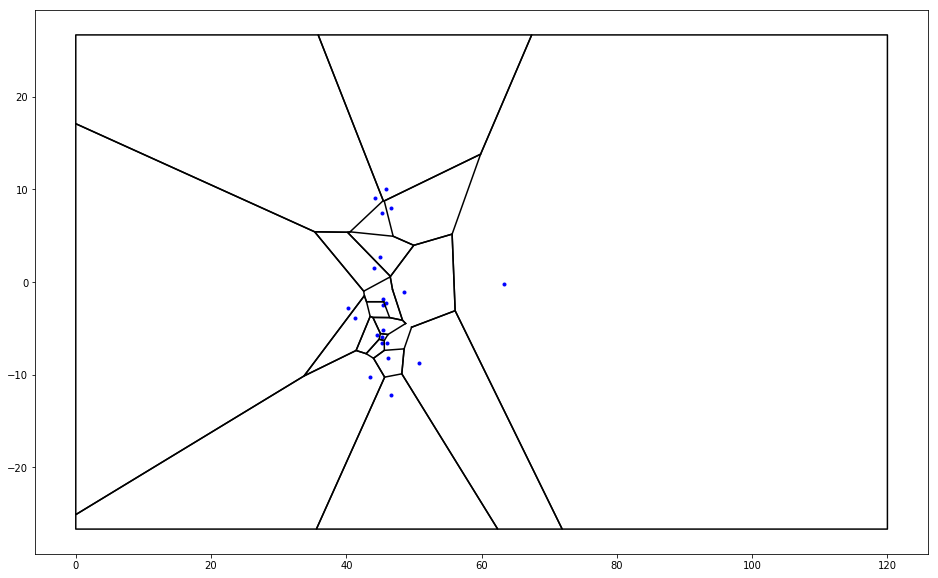

In [120]:
def voronoi_vertices(points_center):    
    bounding_box = np.array([0, 120, -160 / 6, 160 / 6])  # [x_min, x_max, y_min, y_max]

    # Mirror points
    points_left = np.copy(points_center)
    points_left[:, 0] = bounding_box[0] - (points_left[:, 0] - bounding_box[0])
    points_right = np.copy(points_center)
    points_right[:, 0] = bounding_box[1] + (bounding_box[1] - points_right[:, 0])
    points_down = np.copy(points_center)
    points_down[:, 1] = bounding_box[2] - (points_down[:, 1] - bounding_box[2])
    points_up = np.copy(points_center)
    points_up[:, 1] = bounding_box[3] + (bounding_box[3] - points_up[:, 1])
    points = np.append(points_center,
                       np.append(np.append(points_left, points_right, axis=0),
                                 np.append(points_down, points_up, axis=0),
                                 axis=0),
                       axis=0)
    vor = sp.spatial.Voronoi(points)

    point_regions = vor.point_region[0:22]
    all_regions = np.array(vor.regions)
    all_vertices = np.array(vor.vertices)
    vertices = [ all_vertices[r] for r in all_regions[point_regions] ]
    return vertices
    
fig = plt.figure(figsize=(16,10))
ax = fig.gca()
# Plot initial points
ax.plot(points[:, 0], points[:, 1], 'b.')
for vertices in voronoi_vertices(points):
    ax.plot(vertices[:, 0], vertices[:, 1], 'k-')

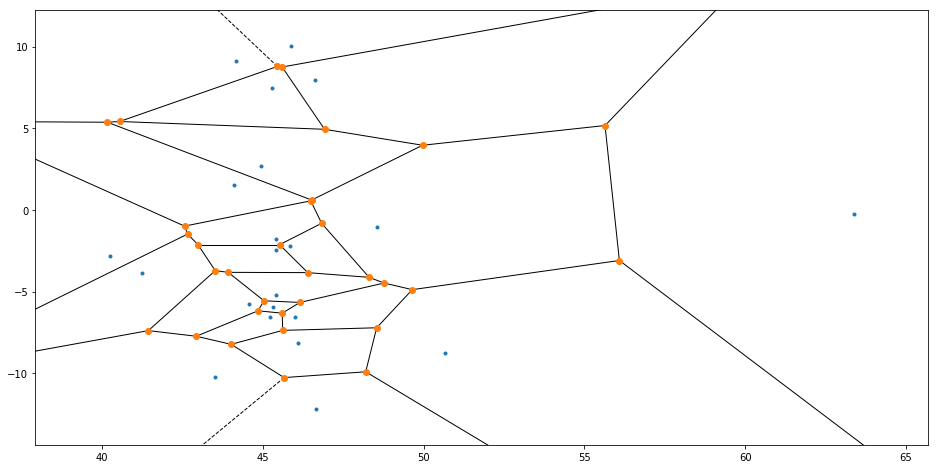

In [177]:
def ishold():
    return True
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.ishold = ishold
voronoi_plot_2d(vor, ax=ax, show_points=True, show_vertices=True)
plt.show()

In [160]:
def voronoi_volumes(points):
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    for i, reg_num in enumerate(v.point_region):
        indices = v.regions[reg_num]
        print("{}: {}".format(i, v.vertices[indices]))
        if -1 in indices: # some regions can be opened
            vol[i] = np.inf
        else:
            vol[i] = ConvexHull(v.vertices[indices]).volume
            
    return vol

In [161]:
voronoi_volumes(points)

0: [[ 44.01981561  -8.23110046]
 [ 45.66612999 -10.26712211]
 [ 48.20204463  -9.91120426]
 [ 48.54258087  -7.21627097]
 [ 45.62074721  -7.3766155 ]]
1: [[45.60723224 -6.32244833]
 [44.85356052 -6.17700291]
 [45.03927657 -5.56333249]
 [46.15576586 -5.66616703]]
2: [[45.60723224 -6.32244833]
 [45.62074721 -7.3766155 ]
 [48.54258087 -7.21627097]
 [49.64970859 -4.88232603]
 [48.77198413 -4.47697691]
 [46.15576586 -5.66616703]]
3: [[48.30808419 -4.12849705]
 [46.83253213 -0.8208012 ]
 [46.49310008  0.55455983]
 [46.52235294  0.60490196]
 [49.97018434  3.95954873]
 [55.6420877   5.16727843]
 [56.08793609 -3.09763602]
 [49.64970859 -4.88232603]
 [48.77198413 -4.47697691]]
4: [[ 48.54258087  -7.21627097]
 [ 49.64970859  -4.88232603]
 [ 56.08793609  -3.09763602]
 [108.53361602 -81.21215227]
 [ 48.20204463  -9.91120426]]
5: [[46.52235294  0.60490196]
 [40.1706619   5.36867024]
 [40.55138567  5.41360038]
 [46.92302638  4.93672083]
 [49.97018434  3.95954873]]
6: [[45.60431701  8.74951097]
 [59.852

array([  9.91602827,   0.63932842,   7.4450476 ,  69.71884974,
       502.66354419,  21.74109591,          inf,  72.22492688,
                inf,          inf,   4.63362595,          inf,
         3.00478593,   7.41904172,  29.95229163,          inf,
                inf,  12.16606274,  25.07740851,   5.6823091 ,
         4.55240772,   7.12576675])

In [134]:
nfl_test = nfl_copy.iloc[0:220]
vor_volumns = nfl_test.groupby(['PlayId']).apply(lambda x: voronoi_volumes(np.array(x[['X_std', 'Y_std']])))

In [145]:
vor_volumns

<bound method Series.ravel of PlayId
20170907000118    [9.916028267024188, 0.6393284153736087, 7.4450...
20170907000139    [inf, 4.709902870368554, 8.26155936118572, 18....
20170907000189    [15.364908105015555, 2.5288609811779357, 11.55...
20170907000345    [0.7433141847554731, inf, 1.7872601484332673, ...
20170907000395    [inf, 86.54440679522817, 8.614389482161487, in...
20170907000473    [inf, 235.67299105581372, 71.11152963674328, i...
20170907000516    [inf, 12.874393219406986, inf, 4.5522215363380...
20170907000653    [34.1368400045351, 0.6952931927049262, 1.36489...
20170907000680    [6.062488839069683, inf, 2.3113747947915115, 4...
20170907000801    [inf, 5.400644801445905, 6.571935481479704, 48...
dtype: object>

(-30, 30)

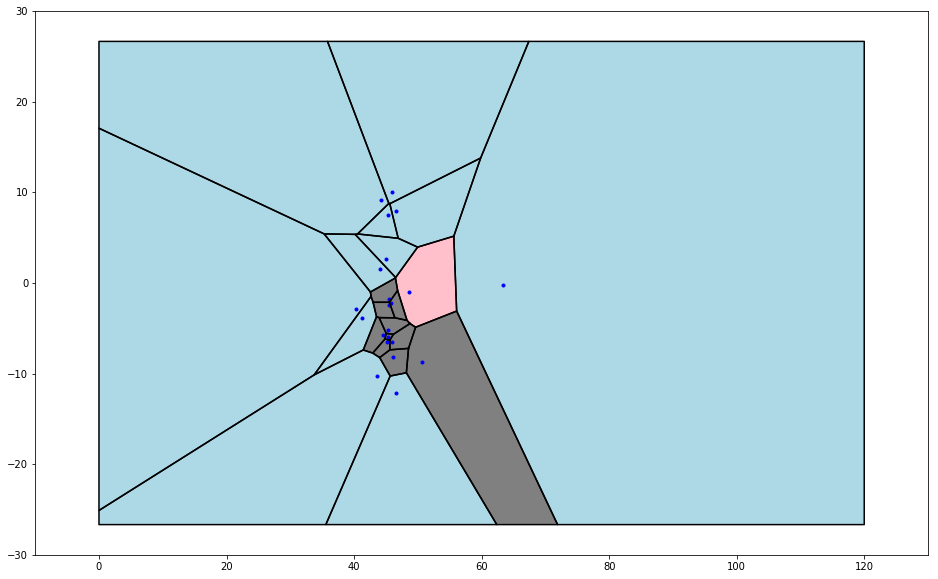

In [213]:
# https://stackoverflow.com/questions/28665491/getting-a-bounded-polygon-coordinates-from-voronoi-cells
eps = sys.float_info.epsilon * 1000

n_towers = 100
towers = points
bounding_box = np.array([0, 120, -160/6, 160/6]) # [x_min, x_max, y_min, y_max]

def in_box(towers, bounding_box):
    return np.logical_and(np.logical_and(bounding_box[0] <= towers[:, 0],
                                         towers[:, 0] <= bounding_box[1]),
                          np.logical_and(bounding_box[2] <= towers[:, 1],
                                         towers[:, 1] <= bounding_box[3]))


def voronoi(towers, bounding_box):
    # Select towers inside the bounding box
    i = in_box(towers, bounding_box)
    # Mirror points
    points_center = towers[i, :]
    points_left = np.copy(points_center)
    points_left[:, 0] = bounding_box[0] - (points_left[:, 0] - bounding_box[0])
    points_right = np.copy(points_center)
    points_right[:, 0] = bounding_box[1] + (bounding_box[1] - points_right[:, 0])
    points_down = np.copy(points_center)
    points_down[:, 1] = bounding_box[2] - (points_down[:, 1] - bounding_box[2])
    points_up = np.copy(points_center)
    points_up[:, 1] = bounding_box[3] + (bounding_box[3] - points_up[:, 1])
    points = np.append(points_center,
                       np.append(np.append(points_left,
                                           points_right,
                                           axis=0),
                                 np.append(points_down,
                                           points_up,
                                           axis=0),
                                 axis=0),
                       axis=0)
    # Compute Voronoi
    vor = sp.spatial.Voronoi(points)
    # Filter regions
    regions = []
    vertices = []
    for region in vor.regions:
        flag = True
        for index in region:
            if index == -1:
                flag = False
                break
            else:
                x = vor.vertices[index, 0]
                y = vor.vertices[index, 1]
                if y == 120.0:
                    print('Here')
                if not(bounding_box[0] - eps <= x and x <= bounding_box[1] + eps and
                       bounding_box[2] - eps <= y and y <= bounding_box[3] + eps):
                    flag = False
                    break
        if region != [] and flag:
            regions.append(region)
            vertices.append(vor.vertices[region + [region[0]], :])
    vor.filtered_points = points_center
    vor.filtered_regions = regions
    vor.filtered_vertices = vertices
    return vor

vor = voronoi(towers, bounding_box)

fig = plt.figure(figsize=(16,10))
ax = fig.gca()
# Plot initial points
ax.plot(vor.filtered_points[:, 0], vor.filtered_points[:, 1], 'b.')
# Plot ridges points
# for region in vor.filtered_regions:
#     vertices = vor.vertices[region, :]
#     ax.plot(vertices[:, 0], vertices[:, 1], 'go')
# Plot ridges
for region in vor.filtered_regions:
    vertices = vor.vertices[region + [region[0]], :]
    ax.plot(vertices[:, 0], vertices[:, 1], 'k-')

count = 0
for vertices in vor.filtered_vertices:
    count+=1
#     vertices = vor.vertices[region + [region[0]], :]
    if count<12:#this is why we have sorted the dataframe before
        plt.fill(*zip(*vertices), "lightblue")
    elif count<22: 
        plt.fill(*zip(*vertices), "grey")
    else:
        plt.fill(*zip(*vertices), "pink")

ax.set_xlim([-10, 130])
ax.set_ylim([-30, 30])

In [230]:
nfl_copy.loc[nfl_copy['Y_std'] >= 160/6, 'Y_std'] = 160/6
# nfl_copy.loc[nfl_copy.PlayId == 20181230022972]
nfl_copy.loc[nfl_copy['Y_std'] < -160/6]

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,S_std,IsRusher,TeamOnOffense,IsOnOffense,ToLeft,YardLine_std,X_std,Y_std,Dir_rad,Dir_std,DisFromPlayStart,RankDisFromPlayStart,IsDefenderInBox
